## License Information
---

This file is distributed as part of `hvsrpy`, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_ and this notebook
---

`hvsrpy` is a Python package for performing horizontal-to-vertical spectral ratio
(H/V) processing. `hvsrpy` was developed by Joseph P. Vantassel with
contributions from Dana M. Brannon under the supervision of Professor Brady R.
Cox at The University of Texas at Austin.  The automated frequency-domain
window-rejection algorithm and log-normal statistics implemented in `hvsrpy` were
developed by Tianjian Cheng under the supervision of Professor Brady R. Cox at
The University of Texas at Austin and are detailed in Cox et al. (2020). See [GitHub](https://github.com/jpvantassel/hvsrpy) for the full citation.

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._


## Getting Started
---
1. Install _hvsrpy_ and its dependencies, with `pip install hvsrpy`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the four provided examples. The names of these files have been written and commented out in the section _Time Domain Settings_ for your convenience. __(~15 minutes)__
3. Try one of your own _miniseed_ files and confirm that, when the same settings are used, the result from _hvsrpy_ exactly matches that of Geopsy. If you get an error related to the _miniseed_ file this likely means it does not conform to the _SEED_ standard (refer to the [hvsrpy documentation](https://hvsrpy.readthedocs.io/en/stable/) for details). __(~15 minutes)__

Happy Processing!

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hvsrpy

## Time Domain Settings
---

In [2]:
# Input file name (may be a relative or full path).
# file_name = "UT.STN11.A2_C50.miniseed"
file_name = "UT.STN11.A2_C150.miniseed"
# file_name = "UT.STN12.A2_C50.miniseed"
# file_name = "UT.STN12.A2_C150.miniseed"

# Window length in seconds. In general low frequency peaks require longer window lengths.
# See the SESAME guidelines for specific window length recommendations.
windowlength = 60

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter.
flow = 0.1                   
# High-cut frequency for bandpass filter.
fhigh = 30                   
# Filter order.
forder = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1

## Frequency Domain Settings
---

In [3]:
# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling
minf = 0.2    
# Maximum frequency after resampling
maxf = 20
# Number of frequencies after resampling
nf = 128
# Type of resampling {'log', 'linear'}
res_type = 'log'

## H/V Settings
---

In [4]:
# Method for combining horizontal components {"squared-average", "geometric-mean", "azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = 'geometric-mean'
# If method='azimuth', set azimuth in degree clock-wise from north. If method!='azimuth', value is ignored.
azimuth = None

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
n_iteration = 50

# Distribution of f0 {"log-normal", "normal"}. Geopsy default "normal" -> "log-normal" is recommended.
distribution_f0 = "log-normal"
# Distribution of mean curve {"log-normal", "normal"}. Geopsy default "log-normal" -> "log-normal" is recommended.
distribution_mc = "log-normal"

## Perform Calculation
---

Elapsed Time: 1.40 seconds

Statistics before rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",0.64,0.28
"Fundamental Site Period, T0",1.57,0.28


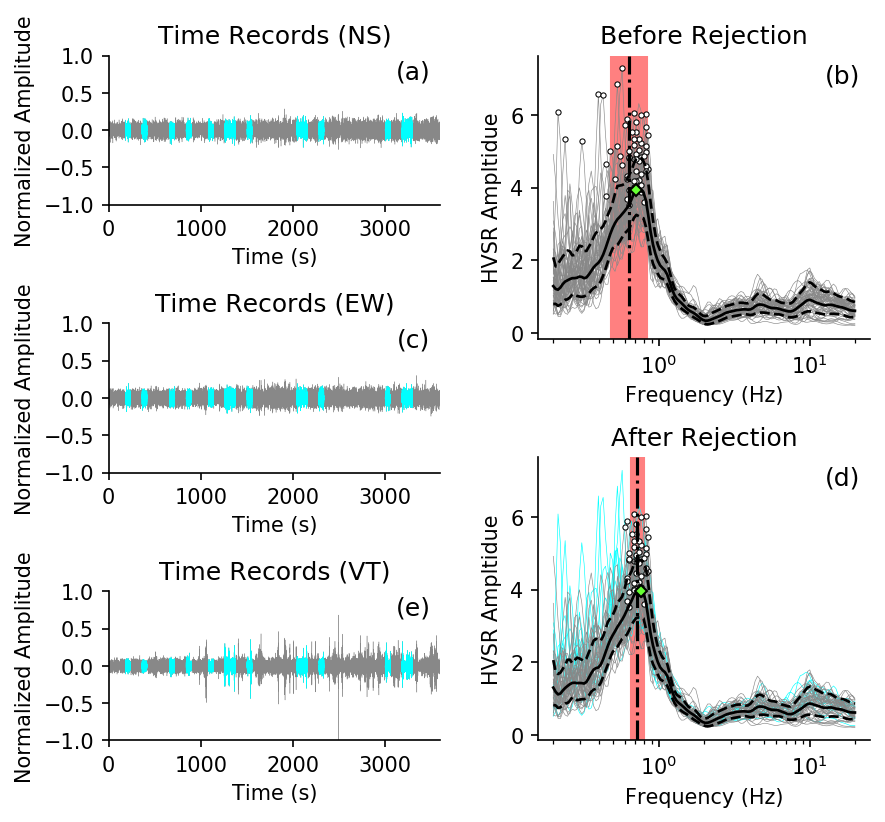

In [5]:
fig = plt.figure(figsize=(6,6), dpi=150)
gs = fig.add_gridspec(nrows=6,ncols=6)

ax0 = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[2:4, 0:3])
ax2 = fig.add_subplot(gs[4:6, 0:3])

if rejection_bool:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = fig.add_subplot(gs[3:6, 3:6])
else:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = False

start = time.time()
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":flow, "fhigh":fhigh, "order":forder}
resampling = {"minf":minf, "maxf":maxf, "nf":nf, "res_type":res_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, azimuth=azimuth)
end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

individual_width = 0.3
median_width = 1.3
for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
    # Rejected Windows
    if title=="After Rejection":
        if len(hv.rejected_window_indices):
            label = "Rejected"
            for amp in hv.amp[hv.rejected_window_indices]:
                ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                label=None
            
    # Accepted Windows
    label="Accepted"
    for amp in hv.amp[hv.valid_window_indices]:
        ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                label = label if title=="Before Rejection" else "")
        label=None
    
    # Window Peaks
    ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
            marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
            label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")
    
    # Peak Mean Curve
    ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
            marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
            label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")
    
    # Mean Curve
    label = r"$LM_{curve}$" if distribution_mc=="log-normal" else "Mean"   
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    # Mean +/- Curve
    label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="log-normal" else "Mean ± 1 STD"
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3,
            label = "" if title=="Before Rejection" and rejection_bool else label)
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3)

    label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="log-normal" else "Mean f0 ± 1 STD"
    ymin, ymax = ax.get_ylim()
    ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [ymin, ymax], linestyle="-.", color="#000000")
    ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [ymin, ymax, ymax, ymin], 
            color = "#ff8080",
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    ax.set_ylim((ymin, ymax))
    ax.set_xscale('log')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("HVSR Ampltidue")
    if rejection_bool:
        if title=="Before Rejection":
            print("\nStatistics before rejection:")
            hv.print_stats(distribution_f0)
            c_iter = hv.reject_windows(n, max_iterations=n_iteration, 
                                       distribution_f0=distribution_f0, distribution_mc=distribution_mc)
        elif title=="After rejection":
            fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

            print("\nAnalysis Summary:")  
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                         data=[f"{windowlength}s", str(sensor.ns.n_windows), f"{c_iter} of {n_iteration} allowed", str(len(hv.rejected_window_indices))]))            
            print("\nStatistics after rejection:")
            hv.print_stats(distribution_f0)
    else:
        display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                         data=[f"{windowlength}s", str(sensor.ns.n_windows)]))
        hv.print_stats(distribution_f0)
        fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
        break
    ax.set_title(title)

norm_factor = sensor.normalization_factor
for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
    ctime = timerecord.time
    amp = timerecord.amp/norm_factor
    ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
    ax.set_title(f"Time Records ({name})")
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(0, windowlength*timerecord.n_windows)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    for window_index in hv.rejected_window_indices:
        ax.plot(ctime[window_index], amp[window_index], linewidth=0.2, color="cyan")
        
if rejection_bool:
    axs = [ax0, ax3, ax1, ax4, ax2]
else:
    axs = [ax0, ax3, ax1, ax2]
    
for ax, letter in zip(axs, list("abcde")):    
    ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)


fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
plt.show()

## Save Figure to File
---

In [6]:
figure_name_out = "example_hvsr_figure.png"

fig.savefig(figure_name_out, dpi=300, bbox_inches='tight')
plt.close()
print("Figure saved successfully!")

Figure saved successfully!


## Save Results to Text File
---

In [7]:
file_name_out = "example_output_hvsrpy.hv"

hv.to_file(file_name_out, distribution_f0, distribution_mc, data_format="hvsrpy")
print("Results saved successfully!")

Results saved successfully!


## Save Results to Geopsy-Style Text File
---

In [8]:
file_name_out = "example_output_geopsy.hv"

hv.to_file(file_name_out, distribution_f0, distribution_mc, data_format="geopsy")
print("Results saved successfully!")

Results saved successfully!
